In [33]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget

import matplotlib.pyplot as plt # For general plotting
import numpy as np
from scipy.stats import multivariate_normal # MVN not univariate
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from modules import models, prob_utils

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

regul_param = .01

In [34]:
X = np.loadtxt(r'C:\Users\ethan\OneDrive - Northeastern University\_Summer 2022\EECE5644 Machine Learning\EECE5644\X_train.txt')
y = np.loadtxt(r'C:\Users\ethan\OneDrive - Northeastern University\_Summer 2022\EECE5644 Machine Learning\EECE5644\y_train.txt')

In [35]:
N = len(X)
labels = y

C = 1 + int(np.max(labels)-np.min(labels)) # Number of classes
L = np.arange(int(np.min(labels)), int(np.max(labels)+1)) # List of class labels

Nl = np.array([sum(labels == l) for l in L]) # Find number of each label

priors = Nl/N # Emprically-derived priors
print('The priors of the classes {} through {} are as follows: {}'.format(int(min(L)), int(max(L)), priors))

# Determine dimensionality from mixture PDF parameters
n = np.prod(X[0,:].shape) # dimensions, aka number of parameters per sample

The priors of the classes 1 through 6 are as follows: [0.16675734 0.14594668 0.13411317 0.17491839 0.18688792 0.1913765 ]


In [36]:
mu = np.zeros((C,n)) # Generates empty mean matrix to store data into
Sigma = np.zeros((n,n,C)) # Generates empty covariance matrix to store data into

for l in L:
    count = int(l-L[0])
    # Hacky way to create matrix with just the rows of a certain class. There is definitely an easier way to do this.
    indices = np.repeat(labels==l, n)
    classValues = np.extract(indices, X).reshape(Nl[count], n)
    mu[count,:] = np.mean(classValues, axis=0)
    Sigma[:,:,count] = np.cov(classValues.T) + regul_param*np.identity(n,n) # Calcs cov matrix for the label, stores it into appropriate index. Add regularization term 


In [37]:
# Min prob. of error classifier
# Conditional likelihoods of each class given x, shape (C, N)
class_cond_likelihoods = np.array([multivariate_normal.pdf(X, mu[c,:], Sigma[:,:,c]) for c in range(C)]) # matrix w/ probability of a given data point being in each class
# Take diag so we have (C, C) shape of priors with prior prob along diagonal
class_priors = np.diag(priors)
# class_priors*likelihood with diagonal matrix creates a matrix of posterior probabilities
# with each class as a row and N columns for samples, e.g. row 1: [p(y1)p(x1|y1), ..., p(y1)p(xN|y1)]
class_posteriors = class_priors.dot(class_cond_likelihoods)

# MAP rule, take largest class posterior per example as your decisions matrix (N, 1)
# Careful of indexing! Added np.ones(N) just for difference in starting from 0 in Python and labels={1,2,3}
decisions = np.argmax(class_posteriors, axis=0) + np.ones(N) * int(min(L))

# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(decisions, labels)
print(conf_mat)
correct_class_samples = np.sum(np.diag(conf_mat)) # Sum the diagonal of the sample matrix to find num correct
print("Total Mumber of Misclassified Samples: {:d}".format(N - correct_class_samples))

# Alternatively work out probability error based on incorrect decisions per class
# perror_per_class = np.array(((conf_mat[1,0]+conf_mat[2,0])/Nl[0], (conf_mat[0,1]+conf_mat[2,1])/Nl[1], (conf_mat[0,2]+conf_mat[1,2])/Nl[2]))
# prob_error = perror_per_class.dot(Nl.T / N)

prob_error = 1 - (correct_class_samples / N)
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))

Confusion Matrix (rows: Predicted class, columns: True class):
[[1226    0    0    0    0    0]
 [   0 1073    1    0    0    0]
 [   0    0  985    0    0    0]
 [   0    0    0 1197    1    0]
 [   0    0    0   89 1373    0]
 [   0    0    0    0    0 1407]]
Total Mumber of Misclassified Samples: 91
Empirically Estimated Probability of Error: 0.0124


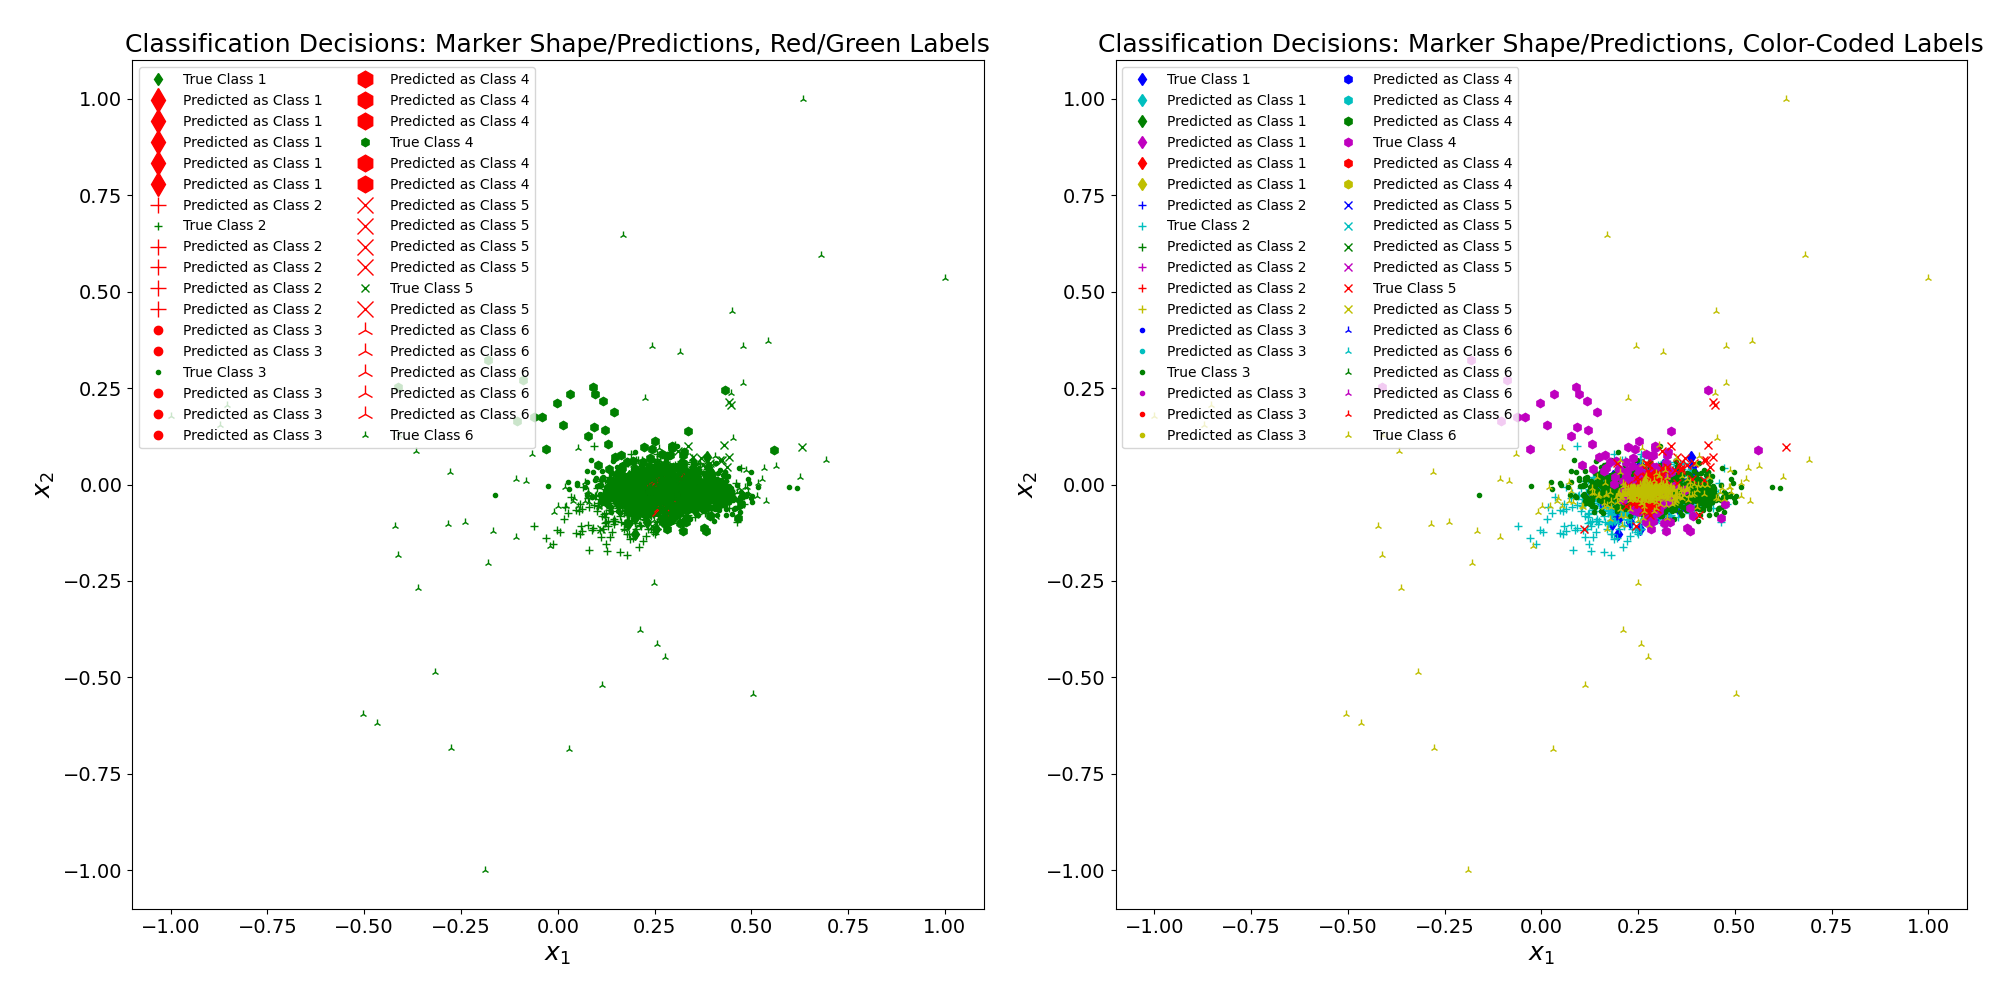

In [52]:
# Plot for decisions vs true labels
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
marker_shapes = 'd+.hx2*'
marker_colors = 'bcgmryb'

for r in L: # Each decision option
    for c in L: # Each class label
        ind_rc = np.argwhere((decisions==r) & (labels==c)) # every index with decision r and label c

        # Decision = Marker Shape; True Labels = Marker Color
        if r == c: # If the decision matches the class (correct)
            ax1.plot(X[ind_rc, 0], X[ind_rc, 1], c='g', marker = marker_shapes[r-min(L)], label="True Class {}".format(c), linestyle = 'None')
            ax2.plot(X[ind_rc, 0], X[ind_rc, 1], c=marker_colors[c-min(L)], marker = marker_shapes[r-min(L)], label="True Class {}".format(c), linestyle = 'None')
        else:
            ax1.plot(X[ind_rc, 0], X[ind_rc, 1], c='r', marker = marker_shapes[r-min(L)], markersize = 12, label="Predicted as Class {}".format(r), linestyle = 'None')
            ax2.plot(X[ind_rc, 0], X[ind_rc, 1], c=marker_colors[c-min(L)], marker = marker_shapes[r-min(L)], label="Predicted as Class {}".format(r), linestyle = 'None')

ax1.legend(ncol=2)
ax2.legend(ncol=2)
ax1.set_xlabel(r"$x_1$")
ax1.set_ylabel(r"$x_2$")
ax2.set_xlabel(r"$x_1$")
ax2.set_ylabel(r"$x_2$")
ax1.set_title("Classification Decisions: Marker Shape/Predictions, Red/Green Labels")
ax2.set_title("Classification Decisions: Marker Shape/Predictions, Color-Coded Labels")
plt.tight_layout()
plt.show()

In [39]:
def perform_pca(X):
    """  Principal Component Analysis (PCA) on real-valued vector data.

    Args:
        X: Real-valued matrix of samples with shape [N, n], N for sample count and n for dimensionality.

    Returns:
         Z: PC projection matrix of the zero-mean input samples, shape [N, n].
    """

    # If using sklearn instead:
    pca = PCA(n_components=X.shape[1])  # n_components is how many PCs we'll keep... let's take all of them
    X_fit = pca.fit(X)  # Is a fitted estimator, not actual data to project
    Z = pca.transform(X)

    return Z


C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\collections.py:564: ComplexWarning: Casting complex values to real discards the imaginary part
  (np.asarray(self.convert_xunits(offsets[:, 0]), 'float'),
C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site

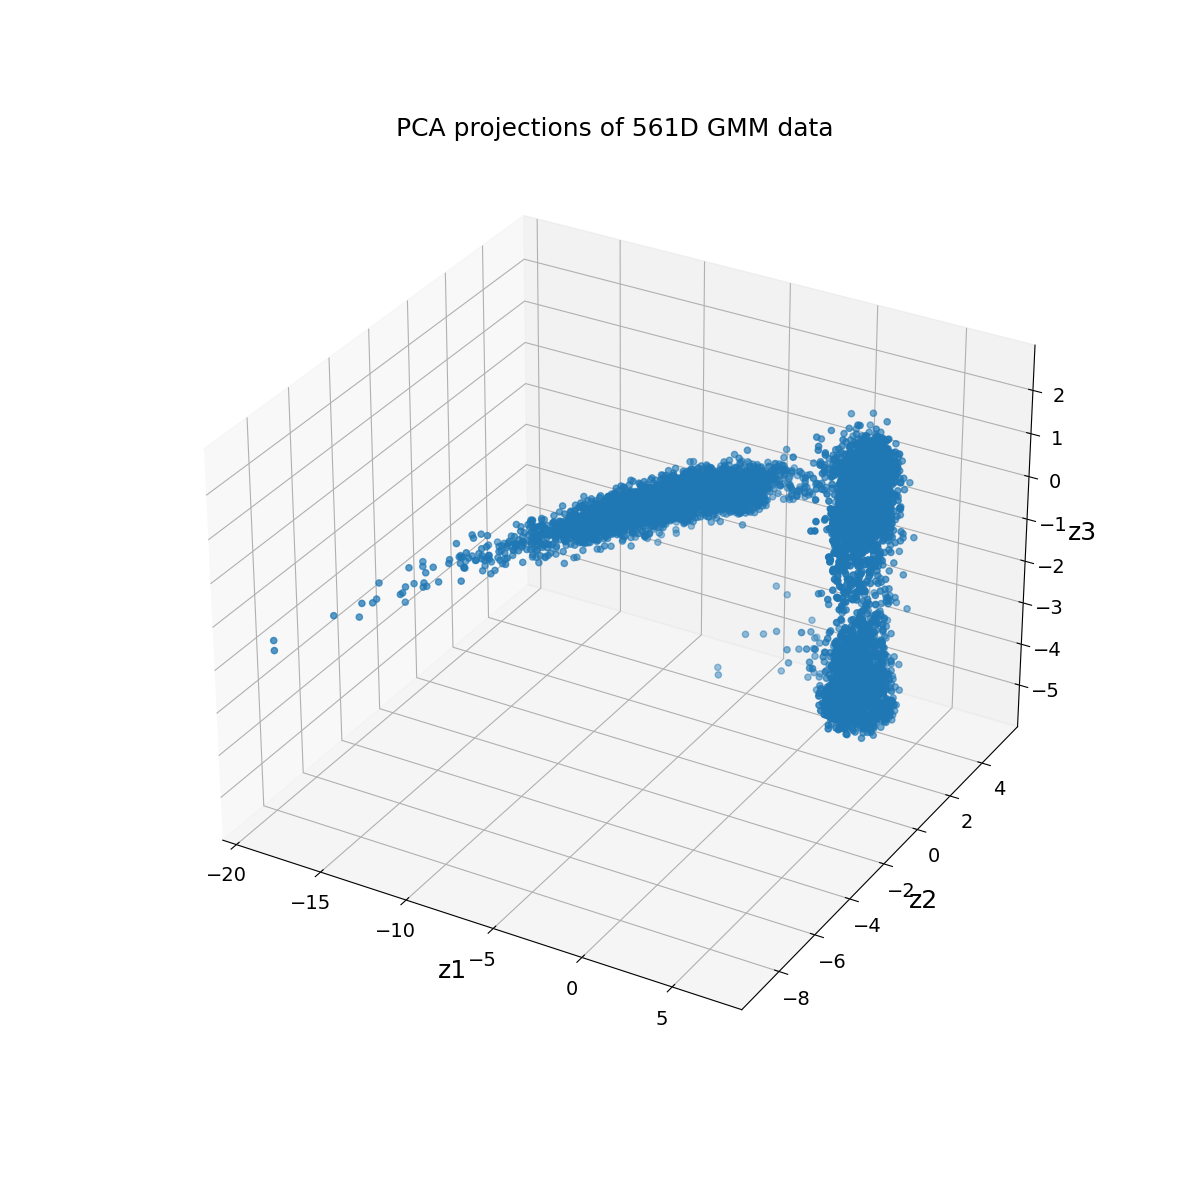

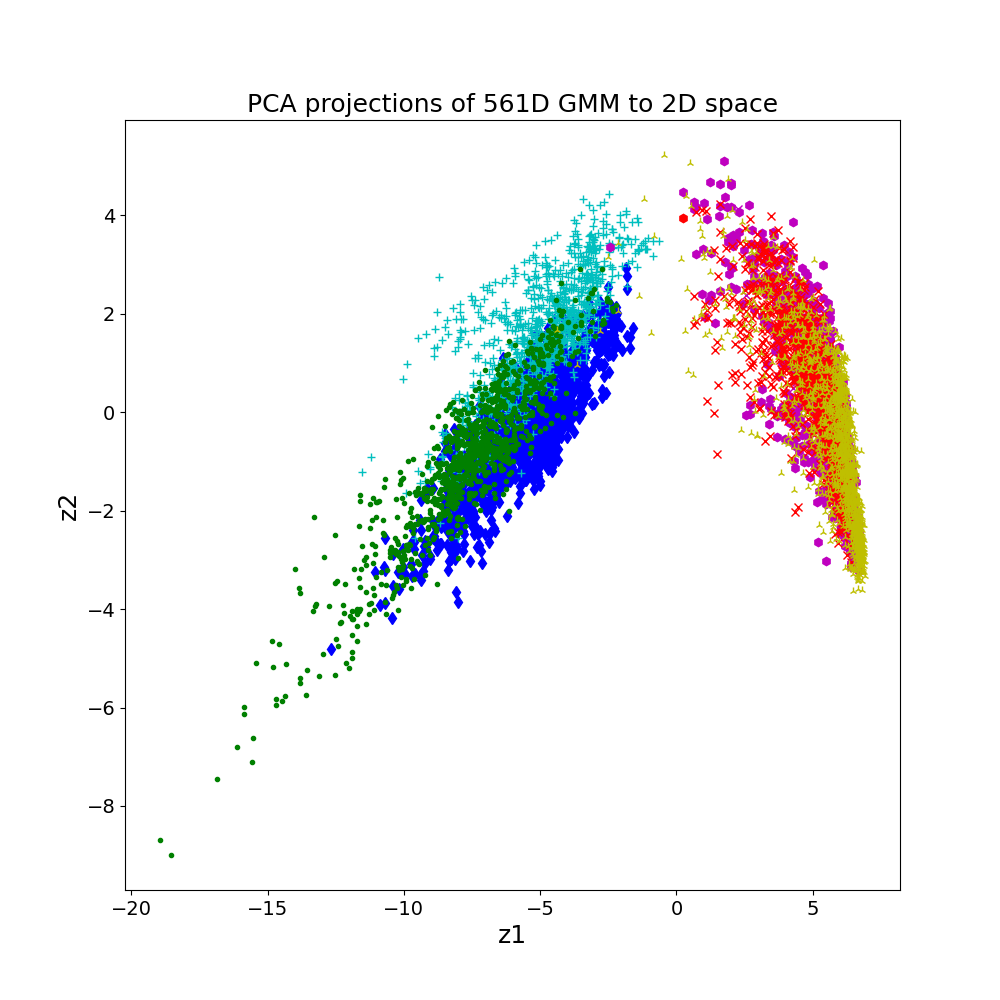

In [53]:
X_GMM = X
# Perform PCA on transposed GMM variable X
_, _, Z = models.perform_pca(X_GMM)

# Add back mean vector to PC projections if you want PCA reconstructions
Z_GMM = Z + np.mean(X_GMM, axis=0)

# Plot original data vs PCA reconstruction data
fig = plt.figure(figsize=(12, 12))

ax2 = fig.add_subplot(projection='3d')
ax2.scatter(Z_GMM[:, 0], Z_GMM[:, 1], Z_GMM[:, 2])
ax2.set_xlabel("z1")
ax2.set_ylabel("z2")
ax2.set_zlabel("z3")
ax2.set_title("PCA projections of {}D GMM data".format(n))
plt.show()


fig = plt.figure(figsize=(10, 10))
marker_shapes = 'd+.hx2*'
marker_colors = 'bcgmryb'

for r in L: # Each decision option
    for c in L: # Each class label
        ind_rc = np.argwhere((decisions==r) & (labels==c)) # every index with decision r and label c

        # Decision = Marker Shape; True Labels = Marker Color
        if r == c: # If the decision matches the class (correct)
            plt.plot(Z_GMM[ind_rc, 0], Z_GMM[ind_rc, 1], c=marker_colors[c-min(L)], marker = marker_shapes[r-min(L)], label="True Class {}".format(c), linestyle = 'None')
        else:
            plt.plot(Z_GMM[ind_rc, 0], Z_GMM[ind_rc, 1], c=marker_colors[c-min(L)], marker = marker_shapes[r-min(L)], label="Predicted as Class {}".format(r), linestyle = 'None') #Plot incorrect labels larger


# Let's see what it looks like only along the first two PCs
# fig = plt.figure(figsize=(10, 10))
# plt.scatter(Z_GMM[:, 0], Z_GMM[:, 1])
plt.xlabel("z1")
plt.ylabel("z2")
plt.title("PCA projections of {}D GMM to 2D space".format(n))
plt.show()
